# Default

In [1]:
import os
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# scipy
from scipy.stats import boxcox, yeojohnson
from scipy.special import inv_boxcox

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import *

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.mosaicplot import mosaic

import tensorflow as tf
import json
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint


from statistics import stdev

import xgboost as xgb 
import lightgbm as lgb

import itertools

from korean_lunar_calendar import KoreanLunarCalendar
from pycaret.classification import *
from pycaret.regression import *
from time import time

from bayes_opt import BayesianOptimization
from catboost import Pool, CatBoostRegressor

# 폰트 설정 - 윈도우
plt.rcParams['font.family'] = 'NanumGothic'

# 그래프의 크기
plt.rcParams['figure.figsize'] = 12, 6

# 글자 크기
plt.rcParams['font.size'] = 14

# 폰트 설정 시 - 기호 깨는거 방지하기
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

# 불필요한 경고 메시지를 나오지 않도록 한다.
import warnings
warnings.filterwarnings('ignore')

# 절기 구분을 위한 모듈
import datetime
dateformat = '%Y-%m-%d'

In [2]:
BASE_DIR = './data'

In [3]:
train_path = os.path.join(BASE_DIR, '2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210902_update.xlsx')

data = pd.read_excel(train_path)
data = data[1 : ]
data = data.reset_index(drop = True)
data.iloc[:,6:] = data.iloc[:,6:].apply(pd.to_numeric)  # 수치형으로 변환
data.columns = ['홍수사상번호', '연', '월', '일', '시간', '유입량', 
                '1_유역평균강수', '1_강우(A지역)', '1_강우(B지역)', '1_강우(C지역)', '1_강우(D지역)', '1_수위(E지역)', '1_수위(D지역)', 
                '2_유역평균강수', '2_강우(A지역)', '2_강우(B지역)', '2_강우(C지역)', '2_강우(D지역)', '2_수위(E지역)', '2_수위(D지역)', 
                '3_유역평균강수', '3_강우(A지역)', '3_강우(B지역)', '3_강우(C지역)', '3_강우(D지역)', '3_수위(E지역)', '3_수위(D지역)',
                '4_유역평균강수', '4_강우(A지역)', '4_강우(B지역)', '4_강우(C지역)', '4_강우(D지역)', '4_수위(E지역)', '4_수위(D지역)',
                '5_유역평균강수', '5_강우(A지역)', '5_강우(B지역)', '5_강우(C지역)', '5_강우(D지역)', '5_수위(E지역)', '5_수위(D지역)',
                '6_유역평균강수', '6_강우(A지역)', '6_강우(B지역)', '6_강우(C지역)', '6_강우(D지역)', '6_수위(E지역)', '6_수위(D지역)']

## 기온

In [4]:
weather_path = os.path.join(BASE_DIR, '기상데이터.csv')

weather_data = pd.read_csv(weather_path, encoding = 'euc-kr')
print('기상데이터 적용 전 :', data.shape)
data = pd.merge(data, weather_data,left_index=True, right_index=True, how='left')

print('기상데이터 적용 후 :', data.shape)

기상데이터 적용 전 : (3051, 48)
기상데이터 적용 후 : (3051, 52)


In [5]:
data_feat = data

# KMEANS

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import *
# from sklearn.cluster import AffinityPropagation

In [7]:
# kmeans를 하기위해서는 변수들이 수치형데이터여야 한다. 그리고 타겟변수인 유입량도 빼준다.
# 그리고 시간의 영향을 제거해보기 위해 시간관련 열들도 제거해본다
data_feat_target = data_feat[data_feat['홍수사상번호'] == 26]
data_feat = data_feat[data_feat['홍수사상번호'] != 26]
data_feat_kmeans = data_feat.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '유입량'], axis = 1)
data_feat_target_kmeans = data_feat_target.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '유입량'], axis = 1)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


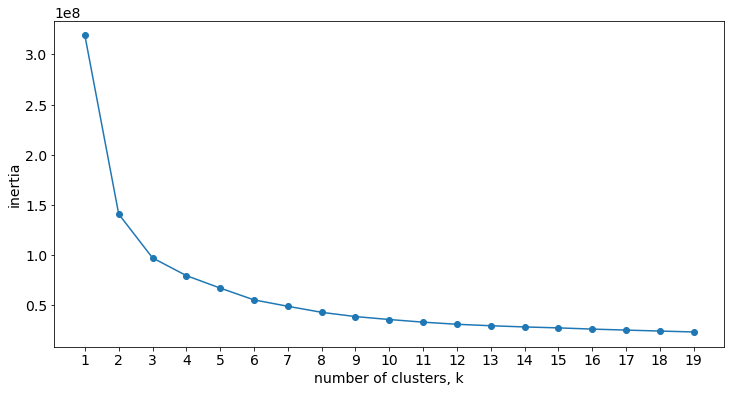

In [8]:
# 과연 몇 개의 군집수가 적당할까 ?

ks = range(1,20)
inertias = []

for k in ks:
  model = KMeans(n_clusters=k)
  model.fit(data_feat_kmeans)
  inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


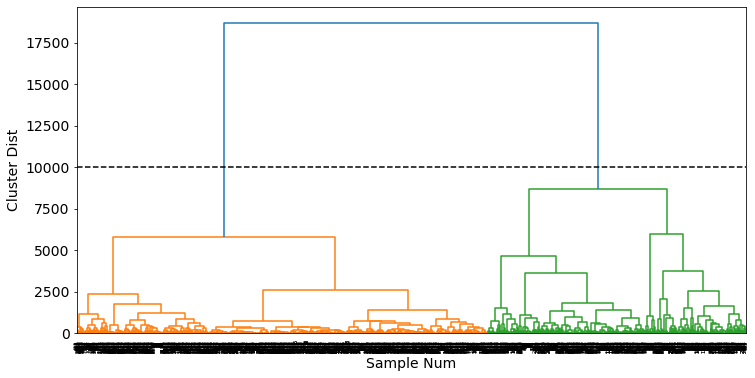

In [9]:
# 검증 덴드로그램
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(data_feat_kmeans)
dendrogram(linkage_array)
plt.xlabel("Sample Num")
plt.ylabel("Cluster Dist")

# 클러스터를 구분하는 커트라인을 표시
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [10000, 10000], '--', c='k')
plt.show()

In [10]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(data_feat_kmeans))

n = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in n:
    agg = AgglomerativeClustering(n_clusters=i)
    cluster = agg.fit(scaled_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d4 = pd.DataFrame()
    d4 = pd.concat([scaled_df,cluster_id],axis=1)
    # d4.columns = [0, 1, "cluster"]
    print('n :', i)
    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d4.iloc[:,:-1], d4.iloc[:, -1])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d4.iloc[:,:-1], d4.iloc[:, -1])))

n : 2
Silhouette Coefficient: 0.4303
Davies Bouldin Index: 1.0662
n : 3
Silhouette Coefficient: 0.2028
Davies Bouldin Index: 1.4931
n : 4
Silhouette Coefficient: 0.2114
Davies Bouldin Index: 1.3012
n : 5
Silhouette Coefficient: 0.2181
Davies Bouldin Index: 1.2188
n : 6
Silhouette Coefficient: 0.2297
Davies Bouldin Index: 1.2773
n : 7
Silhouette Coefficient: 0.2343
Davies Bouldin Index: 1.2350
n : 8
Silhouette Coefficient: 0.2287
Davies Bouldin Index: 1.2822
n : 9
Silhouette Coefficient: 0.2112
Davies Bouldin Index: 1.4779
n : 10
Silhouette Coefficient: 0.2169
Davies Bouldin Index: 1.4938


- 평가는 시각화 및 Silhouette Coefficient, Davies bouldin score로 진행하였다.
- Silhouette Coefficient는 실루엣 계수로 -1 부터 1사이의 값을 가지며 1에 가까울 수록 최적화된 군집이라고 할 수 있다.
- Davies Bouldin Index는 Group 내에서의 Distribution과 비교하여 다른 Group간의 분리 정도의 비율로 계산되는 값으로 모든 두 개의 Group 쌍에 대해 각 Group의 크기의 합을 각 Group의 중심 간 거리로 나눈 값으로서 표현되는 함수이다. 즉, 값이 작을수록 최적화된 군집이라고 할 수 있다.

2개의 군집으로 나눈것이 가장 좋다고 나왔다.

In [11]:
# create model and prediction
scaler = StandardScaler()
model = KMeans(n_clusters=2,algorithm='auto')
pipeline = make_pipeline(scaler,model)
pipeline.fit(data_feat_kmeans)

predict_target = pd.DataFrame(pipeline.predict(data_feat_target_kmeans))
predict_target.columns=['kmeans']
predict = pd.DataFrame(pipeline.predict(data_feat_kmeans))
predict.columns=['kmeans']

In [12]:
# 인덱스 초기화 후 데이터프레임 합치고 다시 원래 인덱스로 되돌리기
data_feat = pd.concat([pd.concat([data_feat, predict], axis = 1), pd.concat([data_feat_target.reset_index(), predict_target], axis = 1).set_index('index')])
data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),5_수위(D지역),6_유역평균강수,6_강우(A지역),6_강우(B지역),6_강우(C지역),6_강우(D지역),6_수위(E지역),6_수위(D지역),일시,기온,풍속,습도,kmeans
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,122.660,6.4000,7,7,8,8,2.54,122.610,2006-07-10 08:00,24.3,2.0,85.0,0
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,122.648,7.3000,7,8,10,10,2.53,122.600,2006-07-10 09:00,24.6,1.5,83.0,0
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,122.636,8.2000,7,9,10,11,2.53,122.590,2006-07-10 10:00,25.4,1.6,79.0,0
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,122.620,11.3000,9,10,15,14,2.53,122.585,2006-07-10 11:00,25.4,0.9,82.0,0
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,122.604,14.4000,12,12,18,16,2.53,122.575,2006-07-10 12:00,25.3,0.8,81.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,129.916,2.1722,1,0,0,0,3.16,129.950,2018-07-07 17:00,23.5,3.6,56.0,0
3047,26.0,2018.0,7.0,7.0,18.0,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,129.928,2.0805,1,0,0,0,3.15,129.970,2018-07-07 18:00,23.2,3.4,56.0,0
3048,26.0,2018.0,7.0,7.0,19.0,NaN,2.3689,1,0,0,0,3.13,130.01250,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,0,0,3.13,130.025000,2.3689,1,0,1,0,3.13,129.910714,2.3689,1,0,1,0,3.13,129.940,2.0354,1,0,0,0,3.13,129.980,2018-07-07 19:00,22.0,3.5,56.0,0
3049,26.0,2018.0,7.0,7.0,20.0,NaN,2.3689,1,0,0,0,3.11,130.01875,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,0,0,3.11,130.025000,2.3689,1,0,1,0,3.11,129.925000,2.3488,1,0,1,0,3.11,129.952,1.8993,1,0,0,0,3.11,129.990,2018-07-07 20:00,20.0,2.3,61.0,0
